# Experiment Design 

**Models**

The phone queueing system was simulated using three models:
- M/M/4, using the estimated parameters from our investigation.
- G/G/4, using the best-fit distribution and estimated parameters from our investigation. This was the gamma distribution for both the interarrival and service times.
- Empirical model, using samples taken from the empirical distribution of the interarrival and service times to simulate the service.

**Additionally**
- We test the G/G/4 model with our scenario of doubling the arrival rate of calls.


**Assumptions**

Each model contained four service units representing four agents taking calls. Although the number of agents fluctuated throughout the day, we chose a constant number based on the typical number of agents rostered on to simplify the models.

Each model also includes the variable *va_prob*, representing the proportion of calls that went to the "voice assistant". Callers are greeted with an automated message with a choice of either speaking to an agent, or leaving a message with the voice assistant. The voice assistant can be considered as an infinite server system, so no queuing takes place. If the caller chooses to speak to an agent, however, they are redirected to the queue which is what we were primarily interested in monitoring. The estimated value for *va_prob* was 150/304. This was based on historical data from the phone management system which captures the different types of calls. Our models assume that this proportion is accurate for all days of the week.


**Simulation**

The code and output for each model and simulation is provided below in the Simulation section. Each simulation is run for a maximum time of 29,700 seconds, which is the maximum amount of time the phone lines are open per day. The random seeds are set to ensure replicability. We captured the following performance measure for each model:

- $W$: Average time in the system (including arrivals of calls sent to voice assistant)
- $L$: Average number of callers in the system
- $B$: Proportion of time the system is busy
- $W_s$: Average time in system (calls sent to agents only)
- $W_q$: Average time in the queue (calls sent to agents only)
- $\lambda_{Eff}$: Effective arrival rate (calls arriving at agents)
- $V$: Proportion of calls sent to voice assistant

# Results

The point estimates and 95% confidence intervals for each performance measure is given in the table below:

|          |Model 1 (M/M/4)   |Model 2 (G/G/4)  |Model 3 (Empirical)|Scenario (G/G/4 with double arrival rate)|
|----------|------------------|-----------------|-------------------|-------------------|
| $W$      | 63.685           | 64.626          | 66.66             |65.766             |
|95% CI    |(61.643, 65.727)  |(63.097, 66.155) |(65.384, 67.936)   |(64.472, 67.059)   |
| $L$      | 0.653            | 0.664           | 0.712             |1.342              |
|95% CI    |(0.631, 0.675)    |(0.639, 0.688)   |(0.697, 0.726)     |(1.305, 1.379)     | 
| $B$      | 0.477            | 0.453           | 0.441             |0.694              |
|95% CI    |(0.466, 0.489)    |(0.441, 0.464)   |(0.435, 0.448)     |(0.684, 0.704)     |
| $W_s$    | 127.074          | 127.471         | 132.552           |129.713            |
|95% CI    |(123.974, 130.174)|(125.25, 129.693)|(132.243, 132.861) |(127.778, 131.648) |
| $W_q$    | 0.139            | 0.252           | 0.435             |1.937              |
|95% CI    |(0.044, 0.235)    |(0.146, 0.358)   |(0.328, 0.541      |(1.58, 2.294)      |
|$\lambda_{Eff}$| 0.005       | 0.005           | 0.005             |0.01               |
|95% CI    |(0.005, 0.005)    |(0.005, 0.005)   |(0.005, 0.005)     |(0.01, 0.011)      |
| $V$      | 0.498            | 0.492           | 0.497             |0.492              |
|95% CI    |(0.49, 0.507)     |(0.485, 0.499)   |(0.488, 0.506)     |(0.487, 0.497)     | 


# Simulations

The code for the three models and simulations are provided in this section. Additionally we simulate a scenario for the G/G/4 model and double the arrival rate of calls.

In [2]:
import numpy
import random
import scipy
import pylab
from SimPy.Simulation import *
import math
import time
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
def conf(L):
    """confidence interval"""
    lower = numpy.mean(L) - 1.96*numpy.std(L)/math.sqrt(len(L))
    upper = numpy.mean(L) + 1.96*numpy.std(L)/math.sqrt(len(L))
    return (round(lower, 3),round(upper, 3))

## Simulation using M/M/4 model

In [3]:
class Source(Process):
    """generate random arrivals"""
    def run(self, N,lamb,mu):
        for i in range(N):
            a = Caller(str(i))
            activate(a, a.run(mu))
            t = random.expovariate(lamb)
            yield hold, self, t
            
class Caller(Process):
    n = 0 # number in system
    def run(self,mu):
        Caller.n += 1 
        arrivetime = now()
        # Observe total number in system
        G.numbermon.observe(Caller.n)
        if (Caller.n>0):
            G.busymon.observe(1)
        else:
            G.busymon.observe(0)
            
        if random.random() > G.va_prob: 
            # Gone to agent
            G.voiceassistmon.observe(0)
            yield request, self, G.agent
            
            # record waiting time in queue
            G.waitmon.observe(now() - arrivetime)
            
            t = random.expovariate(mu)
            yield hold, self, t
            yield release, self, G.agent 
            # observe time that agents are busy
            delay = now() - arrivetime
            G.servicemon.observe(delay)
        else:
            # Gone to voice assistant
            G.voiceassistmon.observe(1)
            G.waitmon.observe(0)
            
        Caller.n -= 1
        G.numbermon.observe(Caller.n)
        if (Caller.n>0):
            G.busymon.observe(1)
        else:
            G.busymon.observe(0)
        # observe time that system is busy
        delay = now()-arrivetime
        G.delaymon.observe(delay)
        
class G:
    va_prob = 150/304 # probability that calls go to virtual assistant
    agent = 'dummy' # resource of c agents
    delaymon = 'Monitor' # monitor total time in system for all callers
    numbermon = 'Monitor' # monitor number of callers
    busymon = 'Monitor' # monitor busy time of system
    servicemon = 'Monitor' # time in system for callers who talk to agents
    voiceassistmon = 'Monitor' # prop. of calls going to voice assistant
    waitmon = "Monitor" # monitor of wait time
    
    
def model1(c, N, lamb,mu,maxtime, rvseed):
    # setup
    initialize()
    random.seed(rvseed)
    G.delaymon = Monitor()
    G.numbermon = Monitor()
    G.busymon = Monitor()
    G.servicemon = Monitor()
    G.voiceassistmon = Monitor()
    G.waitmon = Monitor()
    
    G.agent = Resource(capacity=c, monitored=True)
    Caller.n = 0
   
    # simulate
    s = Source('Source')
    activate(s, s.run(N,lamb,mu))
    simulate(until=maxtime)

    # gather performance measures
    W = G.delaymon.mean()
    L = G.numbermon.timeAverage()
    B = G.busymon.timeAverage()
    
    Ws = G.servicemon.mean()
    Wq = G.waitmon.mean()
    V = G.voiceassistmon.mean()

    Eff_lamb = L/Ws
    
    return W, L, B, Ws, Wq, Eff_lamb, V


In [5]:
# M/M/4 Simulation
allW = []
allL = []
allB = []
allWs = []
allWq = []
allEffLamb = []
allV = []
agents=4

for k in range(50):
    seed = 123*k
    result = model1(c=agents, N=10000,lamb=0.01013,mu=0.007879, 
                    maxtime=29700, rvseed=seed)
    allW.append(result[0])
    allL.append(result[1])
    allB.append(result[2])
    allWs.append(result[3])
    allWq.append(result[4])
    allEffLamb.append(result[5])
    allV.append(result[6])

print("Number of agents:", agents)

print("\nEstimate of W (Average time in system):", 
      round(numpy.mean(allW), 3))
print("Conf int of W:", conf(allW))

print("\nEstimate of L (Average number of callers in system):", 
      round(numpy.mean(allL), 3))
print("Conf int of L:", conf(allL))

print("\nEstimate of B: (Proportion of time system is busy)", 
      round(numpy.mean(allB), 3))
print("Conf int of B:", conf(allB))

print("\nEstimate of Ws (Average time with agent):", 
      round(numpy.mean(allWs), 3))
print("Conf int of Ws:", conf(allWs))

print("\nEstimate of Wq (Average time in queue):", 
      round(numpy.mean(allWq), 3))
print("Conf int of Wq:", conf(allWq))

print("\nEstimate of EffLamb (Effective Arrival Rate):", 
      round(numpy.mean(allEffLamb), 3))
print("Conf int of EffLamb:", conf(allEffLamb))

print("\nEstimate of V (Proportion of calls sent to Voice Assist):", 
      round(numpy.mean(allV), 3))
print("Conf int of V:", conf(allV))

Number of agents: 4

Estimate of W (Average time in system): 63.685
Conf int of W: (61.643, 65.727)

Estimate of L (Average number of callers in system): 0.653
Conf int of L: (0.631, 0.675)

Estimate of B: (Proportion of time system is busy) 0.477
Conf int of B: (0.466, 0.489)

Estimate of Ws (Average time with agent): 127.074
Conf int of Ws: (123.974, 130.174)

Estimate of Wq (Average time in queue): 0.139
Conf int of Wq: (0.044, 0.235)

Estimate of EffLamb (Effective Arrival Rate): 0.005
Conf int of EffLamb: (0.005, 0.005)

Estimate of V (Proportion of calls sent to Voice Assist): 0.498
Conf int of V: (0.49, 0.507)


## Simulation using G/G/4 Model

In [6]:
class Source(Process):
    def run(self, N):
        for i in range(N):
            c = Caller(name = f"Caller {i}")
            activate(c, c.run())
            t = random.gammavariate(G.arr_shape, G.arr_mu)
            yield hold, self, t

class Caller(Process):
    n = 0
    def run(self):
        Caller.n += 1
        arrivetime = now()
        G.numbermon.observe(Caller.n)
        if (Caller.n > 0):
            G.busymon.observe(1) 
        else:
            G.busymon.observe(0)
        if random.random() > G.va_prob:
            G.voiceassistmon.observe(0)
            # Call goes to agent
            yield request, self, G.agent
            G.waitmon.observe(now() - arrivetime)
            t = random.gammavariate(G.ser_shape, G.ser_mu)
            yield hold, self, t
            yield release, self, G.agent
            delay = now() - arrivetime
            G.servicemon.observe(delay)
        else:
            # Call goes to voice assistant
            G.voiceassistmon.observe(1)
            G.waitmon.observe(0)
        Caller.n -= 1
        G.numbermon.observe(Caller.n)
        if (Caller.n > 0):
            G.busymon.observe(1) 
        else:
            G.busymon.observe(0)
            
        delay = now() - arrivetime
        G.delaymon.observe(delay)

class G:
    # Estimated Gamma Parameters
    arr_mu = 1/0.005845 #scale
    arr_shape = 0.577
    ser_mu = 1/0.01093
    ser_shape = 1.387
    
    va_prob = 150/304 # probability that calls go to virtual assistant
    agent = 'dummy' # resource of c agents
    delaymon = 'Monitor' # monitor total time in system for all callers
    numbermon = 'Monitor' # monitor number of callers
    busymon = 'Monitor' # monitor busy time of system
    servicemon = 'Monitor' # time in system for callers who talk to agents
    voiceassistmon = 'Monitor' # prop. of calls going to voice assistant
    waitmon = "Monitor" # monitor of wait time


def model2(c, N, maxtime = 200000, rvseed = 12345):
    # setup
    initialize()
    random.seed(seed)
    G.busymon = Monitor()
    G.waitmon = Monitor()
    G.delaymon = Monitor()
    G.numbermon = Monitor()
    G.servicemon = Monitor()
    G.voiceassistmon = Monitor()
    
    G.agent = Resource(capacity=c, monitored=True)
    Caller.n = 0
    
    # simulate    
    s = Source()
    activate(s, s.run(N))
    simulate(until=maxtime)

    # gather performance metrics
    L = G.numbermon.timeAverage()
    Wq = G.waitmon.mean()
    B = G.busymon.timeAverage()
    Ws = G.servicemon.mean()
    W = G.delaymon.mean()
    V = G.voiceassistmon.mean()
    Eff_lamb = L/Ws
    
    return W, L, B, Ws, Wq, Eff_lamb, V


In [7]:
# G/G/4 Simulation
allW = []
allL = []
allB = []
allWs = []
allWq = []
allEffLamb = []
allV = []
agents=4

for k in range(50):
    seed = 123*k
    result = model2(c=agents, N=10000, maxtime=29700, rvseed=seed)
    allW.append(result[0])
    allL.append(result[1])
    allB.append(result[2])
    allWs.append(result[3])
    allWq.append(result[4])
    allEffLamb.append(result[5])
    allV.append(result[6])

print("Number of agents:", agents)

print("\nEstimate of W (Average time in system):", 
      round(numpy.mean(allW), 3))
print("Conf int of W:", conf(allW))

print("\nEstimate of L (Average number of callers in system):", 
      round(numpy.mean(allL), 3))
print("Conf int of L:", conf(allL))

print("\nEstimate of B: (Proportion of time system is busy)", 
      round(numpy.mean(allB), 3))
print("Conf int of B:", conf(allB))

print("\nEstimate of Ws (Average time with agent):", 
      round(numpy.mean(allWs), 3))
print("Conf int of Ws:", conf(allWs))

print("\nEstimate of Wq (Average time in queue):", 
      round(numpy.mean(allWq), 3))
print("Conf int of Wq:", conf(allWq))

print("\nEstimate of EffLamb (Effective Arrival Rate):", 
      round(numpy.mean(allEffLamb), 3))
print("Conf int of EffLamb:", conf(allEffLamb))

print("\nEstimate of V (Proportion of calls sent to Voice Assist):", 
      round(numpy.mean(allV), 3))
print("Conf int of V:", conf(allV))


Number of agents: 4

Estimate of W (Average time in system): 64.626
Conf int of W: (63.097, 66.155)

Estimate of L (Average number of callers in system): 0.664
Conf int of L: (0.639, 0.688)

Estimate of B: (Proportion of time system is busy) 0.453
Conf int of B: (0.441, 0.464)

Estimate of Ws (Average time with agent): 127.471
Conf int of Ws: (125.25, 129.693)

Estimate of Wq (Average time in queue): 0.252
Conf int of Wq: (0.146, 0.358)

Estimate of EffLamb (Effective Arrival Rate): 0.005
Conf int of EffLamb: (0.005, 0.005)

Estimate of V (Proportion of calls sent to Voice Assist): 0.492
Conf int of V: (0.485, 0.499)


## Simulation using Empirical Data

In [8]:
# Read in the data and process times
data = pd.read_excel('/Users/sharnag/jupyter/DATA474/Project/Group 1 data.xlsx', sheet_name='Data')

arrivalt = data["Arrival time"]
interarrivaltimes = []
for i in range(len(arrivalt)-1):
    j = arrivalt[i]
    j = (j.second + j.minute*60 + j.hour*60*60)
    k = arrivalt[i+1]
    k = (k.second + k.minute*60 + k.hour*60*60)
    if k-j < 3600 and k-j > 0:
        interarrivaltimes.append(k-j)
        
servicetime = []
st = data["Service time"]
for i in range(len(st)-1):
    j = st[i]
    j = (j.second + j.minute*60 + j.hour*60*60)
    if j > 0 and j < 3600:
        servicetime.append(j)

In [9]:
# Define function to draw from empiral cdf
def draw_empirical(data, r):
    """one draw from the empirical cdf based on data"""
    d = {x:data.count(x) for x in data}
    obs_values, freq = zip( *sorted( zip(d.keys(), d.values())))
    obs_values = list(obs_values)
    freq = list(freq)
    empf = [x*1.0/len(data) for x in freq]
    ecum = numpy.cumsum(empf).tolist()
    ecum.insert(0, 0)
    obs_values.insert(0,0)
    for x in ecum:
        if r <= x:
            rpt = x
            break
    r_end = ecum.index(rpt)
    y = obs_values[r_end] - 1.0*(ecum[r_end]-r)*(obs_values[r_end]-
                    obs_values[r_end-1])/(ecum[r_end]-ecum[r_end-1])
    return y

In [10]:
# Generate 10,000 samples of new Interarrival and Service times
N = 10000
numpy.random.seed(123)
IAT_new = [draw_empirical(interarrivaltimes, r) for r in 
           numpy.random.uniform(size=N)]
ST_new = [draw_empirical(servicetime, r) for r in 
          numpy.random.uniform(size=N)]

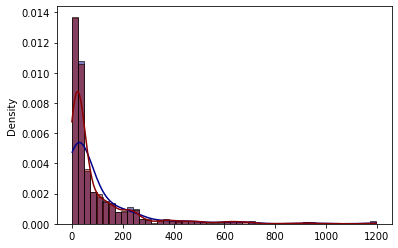

In [11]:
# Compare the distributions of the original and sampled data
sns.histplot(interarrivaltimes, bins=50, kde=True, color = 'darkblue', 
             stat='density');
sns.histplot(IAT_new, bins=50, kde=True, color = 'darkred', 
             stat='density');

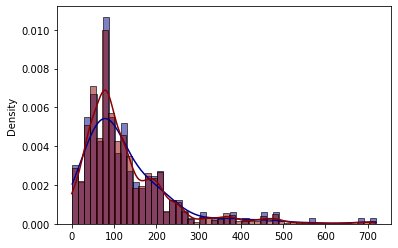

In [12]:
sns.histplot(servicetime, bins=50, kde=True, color = 'darkblue', 
             stat='density');
sns.histplot(ST_new, bins=50, kde=True, color = 'darkred', 
             stat='density');

In [13]:
# Simulation Setup
class Source(Process):
    """generate caller interarrival times from empiral distribution"""
    def run(self, N):
        for i in range(N):
            a = Caller(str(i))
            activate(a, a.run())
            t = IAT_new[i] # retrieve from sampled distribution
            yield hold, self, t
            
class Caller(Process):
    n = 0
    service_counter = 0 # for drawing service times
    
    def run(self):
        Caller.n += 1
        arrivetime = now()
        G.numbermon.observe(Caller.n)
        if (Caller.n > 0):
            G.busymon.observe(1) 
        else:
            G.busymon.observe(0)
        
        if random.random() > G.va_prob:
            G.voiceassistmon.observe(0)
            # Gone to agent
            yield request, self, G.agent
            G.waitmon.observe(now() - arrivetime)
            # draw from sampled service times
            t = ST_new[Caller.service_counter] 
            Caller.service_counter +=1
            yield hold, self, t
            yield release, self, G.agent
            delay = now() - arrivetime
            G.servicemon.observe(delay)
        else:
            # Gone to voice assistant
            G.voiceassistmon.observe(1)
            G.waitmon.observe(0)
        Caller.n -= 1
        G.numbermon.observe(Caller.n)
        if (Caller.n > 0):
            G.busymon.observe(1) 
        else:
            G.busymon.observe(0)
            
        delay = now() - arrivetime
        G.delaymon.observe(delay)
        
        # Uncomment to track "warm up" period
        #W = G.delaymon.mean()
        #G.trackW.observe(W)
        

class G:
    va_prob = 150/304 # probability that calls go to virtual assistant
    agent = 'dummy' # resource of c agents
    delaymon = 'Monitor' # monitor total time in system for all callers
    numbermon = 'Monitor' # monitor number of callers
    busymon = 'Monitor' # monitor busy time of system
    servicemon = 'Monitor' # time in system for callers who talk to agents
    voiceassistmon = 'Monitor' # prop. of calls going to voice assistant
    waitmon = "Monitor" # monitor of wait time    
    #trackW = 'for plotting' # Uncomment to track "warm up" period

def model3(c, N, maxtime = 200000, rvseed = 12345):
    # setup
    initialize()
    random.seed(seed)
    G.busymon = Monitor()
    G.waitmon = Monitor()
    G.delaymon = Monitor()
    G.numbermon = Monitor()
    G.servicemon = Monitor()
    G.voiceassistmon = Monitor()
    #G.trackW = Monitor() # Uncomment to track "warm up" period
    
    G.agent = Resource(capacity=c, monitored=True)
    Caller.n = 0
    Caller.service_counter = 0
    
    # simulate    
    s = Source()
    activate(s, s.run(N))
    simulate(until=maxtime)

    # gather performance metrics
    L = G.numbermon.timeAverage()
    Wq = G.waitmon.mean()
    B = G.busymon.timeAverage()
    Ws = G.servicemon.mean()
    W = G.delaymon.mean()
    V = G.voiceassistmon.mean()
    Eff_lamb = L/Ws
    
    return W, L, B, Ws, Wq, Eff_lamb, V

In [14]:
# Simulation using empirical data
allW = []
allL = []
allB = []
allWs = []
allWq = []
allEffLamb = []
allV = []
agents = 4

for k in range(50):
    seed = 123*k
    result = model3(c=agents, N=10000, maxtime=29700, rvseed=seed) 
    # if increasing N, you must also increase the number of sampled times
    allW.append(result[0])
    allL.append(result[1])
    allB.append(result[2])
    allWs.append(result[3])
    allWq.append(result[4])
    allEffLamb.append(result[5])
    allV.append(result[6])

print("Number of agents:", agents)

print("\nEstimate of W (Average time in system):", 
      round(numpy.mean(allW), 3))
print("Conf int of W:", conf(allW))

print("\nEstimate of L (Average number of callers in system):", 
      round(numpy.mean(allL), 3))
print("Conf int of L:", conf(allL))

print("\nEstimate of B: (Proportion of time system is busy)", 
      round(numpy.mean(allB), 3))
print("Conf int of B:", conf(allB))

print("\nEstimate of Ws (Average time with agent):", 
      round(numpy.mean(allWs), 3))
print("Conf int of Ws:", conf(allWs))

print("\nEstimate of Wq (Average time in queue):", 
      round(numpy.mean(allWq), 3))
print("Conf int of Wq:", conf(allWq))

print("\nEstimate of EffLamb (Effective Arrival Rate):", 
      round(numpy.mean(allEffLamb), 3))
print("Conf int of EffLamb:", conf(allEffLamb))

print("\nEstimate of V (Proportion of calls sent to Voice Assist):", 
      round(numpy.mean(allV), 3))
print("Conf int of V:", conf(allV))

Number of agents: 4

Estimate of W (Average time in system): 66.66
Conf int of W: (65.384, 67.936)

Estimate of L (Average number of callers in system): 0.712
Conf int of L: (0.697, 0.726)

Estimate of B: (Proportion of time system is busy) 0.441
Conf int of B: (0.435, 0.448)

Estimate of Ws (Average time with agent): 132.552
Conf int of Ws: (132.243, 132.861)

Estimate of Wq (Average time in queue): 0.435
Conf int of Wq: (0.328, 0.541)

Estimate of EffLamb (Effective Arrival Rate): 0.005
Conf int of EffLamb: (0.005, 0.005)

Estimate of V (Proportion of calls sent to Voice Assist): 0.497
Conf int of V: (0.488, 0.506)


In [15]:
# Optional - plot showing warm up period
# Uncomment code labeled <Uncomment to track "warm up" period>
#plt.plot(G.trackW.tseries(),G.trackW.yseries(),'k-')
#plt.show()

## Simulation of Scenario
Double the arrival rate of calls

99.24390752309847
49.312030609627676


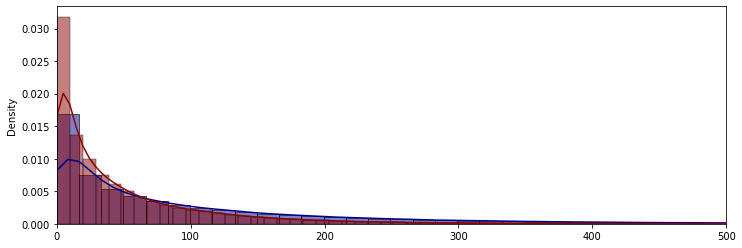

In [67]:
# Compare the distributions of the original and scenario data
fig,ax = plt.subplots(figsize=(12,4))

x1 = [random.gammavariate(alpha=0.577, beta=1/0.005845) for i in range(100000)]
x2 = [random.gammavariate(alpha=0.577, beta=0.5*(1/0.005845)) for i in range(100000)]
# In this case, beta is the scale parameter. Rate is: 0.005845, Scale is: 1/0.005845
# Need to half the scale to double the interarrival rate


sns.histplot(x1, bins=100, kde=True, color = 'darkblue', 
             stat='density');
sns.histplot(x2, bins=100, kde=True, color = 'darkred', alpha=0.5,
             stat='density');

ax.set(xlim=(0, 500));

print(numpy.mean(x1))
print(numpy.mean(x2))

In [104]:
class Source(Process):
    def run(self, N):
        for i in range(N):
            c = Caller(name = f"Caller {i}")
            activate(c, c.run())
            t = random.gammavariate(G.arr_shape, G.arr_mu_double) # test with half the scale/double the arrival
            yield hold, self, t

class Caller(Process):
    n = 0
    def run(self):
        Caller.n += 1
        arrivetime = now()
        G.numbermon.observe(Caller.n)
        if (Caller.n > 0):
            G.busymon.observe(1) 
        else:
            G.busymon.observe(0)
        
        if random.random() > G.va_prob:
            # Call goes to agent
            G.voiceassistmon.observe(0) 
            yield request, self, G.agent 
            G.waitmon.observe(now() - arrivetime)
            t = random.gammavariate(G.ser_shape, G.ser_mu)
            yield hold, self, t
            yield release, self, G.agent
            delay = now() - arrivetime
            G.servicemon.observe(delay)
        else:
            # Call goes to voice assistant
            G.voiceassistmon.observe(1)
            G.waitmon.observe(0)
        Caller.n -= 1
        G.numbermon.observe(Caller.n)
        if (Caller.n > 0):
            G.busymon.observe(1) 
        else:
            G.busymon.observe(0)    
        delay = now() - arrivetime
        G.delaymon.observe(delay)

class G:
    # Estimated Gamma Parameters
    arr_mu = 1/0.005845
    arr_mu_double = 0.5 * (1/0.005845) # half the scale/ double the rate
    arr_shape = 0.577
    ser_mu = 1/0.01093
    ser_shape = 1.387
    
    
    va_prob = 150/304 # probability that calls go to virtual assistant
    agent = 'dummy' # resource of c agents
    delaymon = 'Monitor' # monitor total time in system for all callers
    numbermon = 'Monitor' # monitor number of callers
    busymon = 'Monitor' # monitor busy time of system
    servicemon = 'Monitor' # time in system for callers who talk to agents
    voiceassistmon = 'Monitor' # prop. of calls going to voice assistant
    waitmon = "Monitor" # monitor of wait time


def model4(c, N, maxtime = 200000, rvseed = 12345):
    # setup
    initialize()
    random.seed(seed)
    G.busymon = Monitor()
    G.waitmon = Monitor()
    G.delaymon = Monitor()
    G.numbermon = Monitor()
    G.servicemon = Monitor()
    G.voiceassistmon = Monitor()
    
    G.agent = Resource(capacity=c, monitored=True)
    Caller.n = 0
    
    # simulate    
    s = Source()
    activate(s, s.run(N))
    simulate(until=maxtime)

    # gather performance metrics
    L = G.numbermon.timeAverage()
    Wq = G.waitmon.mean()
    B = G.busymon.timeAverage()
    Ws = G.servicemon.mean()
    W = G.delaymon.mean()
    V = G.voiceassistmon.mean()
    Eff_lamb = L/Ws
    
    return W, L, B, Ws, Wq, Eff_lamb, V


In [105]:
# Scenario -  G/G/4 Simulation
allW = []
allL = []
allB = []
allWs = []
allWq = []
allEffLamb = []
allV = []
agents=4

for k in range(50):
    seed = 123*k
    result = model4(c=agents, N=10000, maxtime=29700, rvseed=seed)
    allW.append(result[0])
    allL.append(result[1])
    allB.append(result[2])
    allWs.append(result[3])
    allWq.append(result[4])
    allEffLamb.append(result[5])
    allV.append(result[6])

print("Number of agents:", agents)

print("\nEstimate of W (Average time in system):", 
      round(numpy.mean(allW), 3))
print("Conf int of W:", conf(allW))

print("\nEstimate of L (Average number of callers in system):", 
      round(numpy.mean(allL), 3))
print("Conf int of L:", conf(allL))

print("\nEstimate of B: (Proportion of time system is busy)", 
      round(numpy.mean(allB), 3))
print("Conf int of B:", conf(allB))

print("\nEstimate of Ws (Average time with agent):", 
      round(numpy.mean(allWs), 3))
print("Conf int of Ws:", conf(allWs))

print("\nEstimate of Wq (Average time in queue):", 
      round(numpy.mean(allWq), 3))
print("Conf int of Wq:", conf(allWq))

print("\nEstimate of EffLamb (Effective Arrival Rate):", 
      round(numpy.mean(allEffLamb), 3))
print("Conf int of EffLamb:", conf(allEffLamb))

print("\nEstimate of V (Proportion of calls sent to Voice Assist):", 
      round(numpy.mean(allV), 3))
print("Conf int of V:", conf(allV))

Number of agents: 4

Estimate of W (Average time in system): 65.766
Conf int of W: (64.472, 67.059)

Estimate of L (Average number of callers in system): 1.342
Conf int of L: (1.305, 1.379)

Estimate of B: (Proportion of time system is busy) 0.694
Conf int of B: (0.684, 0.704)

Estimate of Ws (Average time with agent): 129.713
Conf int of Ws: (127.778, 131.648)

Estimate of Wq (Average time in queue): 1.937
Conf int of Wq: (1.58, 2.294)

Estimate of EffLamb (Effective Arrival Rate): 0.01
Conf int of EffLamb: (0.01, 0.011)

Estimate of V (Proportion of calls sent to Voice Assist): 0.492
Conf int of V: (0.487, 0.497)
